In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge

In [4]:
df = pd.read_csv('dataset/houses_to_rent_v2.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


Informações sobre o dataset:

city (cidade): cidade onde o imóvel está situado.

área: Refere-se à metragem quadrada total do imóvel.

rooms (quartos): Indica o número de quartos no imóvel.

bathroom (banheiro): Representa a quantidade de banheiros no imóvel.

parking spaces (garagens): Corresponde ao número de vagas de estacionamento associadas ao imóvel (andar).

floor: Descreve o andar específico em que o imóvel está situado.

furniture (mobília): Indica se o imóvel está mobiladoou não.

hoa  (valor do condomínio): Corresponde à taxa mensal do condomínio associada ao imóvel.

rent amount (aluguel): Refere-se à quantia mensal de aluguel cobrada pelo imóvel.

property tax (IPTU): Representa o valor do Imposto Predial e Territorial Urbano (IPTU) associado ao imóvel.

fire insurance (seguro de incêndio): Corresponde ao valor mensal do seguro contra incêndio para o imóvel.

total: Refere-se ao montante total das despesas mensais do imóvel, incluindo aluguel, condomínio, IPTU e seguro contra incêndio.

In [6]:
# Traduzindo as colunas do dataframe para português
df_translated = df.rename(columns={
    'city' : 'cidade', 'rooms' : 'quartos', 'bathroom' : 'banheiro', 'parking spaces' : 'garagens',
    'floor' : 'andar', 'furniture' : 'mobilia', 'hoa (R$)' : 'valor_condominio', 'rent amount (R$)' : 'aluguel',
    'property tax (R$)' : 'iptu', 'fire insurance (R$)' : 'seguro incêndio', 'total (R$)' : 'total_despesas'
    })

# Modificando os valores das colunas 'animal' e 'mobília' para booleanos
df_translated.replace({'acept' : True, 'not acept' : False, 'furnished' : True, 'not furnished' : False}, inplace=True)

df_translated.drop_duplicates(inplace=True)

# Criando uma coluna de total de custos / área:
df_translated['preco_por_m2'] = df_translated['total_despesas'] / df_translated['area']

# Transformando a coluna 'andar' em int e removendo possíveis outliers
df_translated['andar'].replace({'-' : np.NaN}, inplace=True)
df_translated['andar'] = df_translated['andar'].astype(float)
df_translated = df_translated[df_translated['andar'] < 40]

low, high = df_translated['preco_por_m2'].quantile([0.001, 0.999])
df_translated = df_translated[df_translated['preco_por_m2'].between(low, high)].sort_values(by= 'preco_por_m2', ascending=True)

# Resetando o índice
df_translated.reset_index(inplace=True)
df_translated.drop(columns='index', inplace=True)

In [7]:
df_translated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7944 entries, 0 to 7943
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cidade            7944 non-null   object 
 1   area              7944 non-null   int64  
 2   quartos           7944 non-null   int64  
 3   banheiro          7944 non-null   int64  
 4   garagens          7944 non-null   int64  
 5   andar             7944 non-null   float64
 6   animal            7944 non-null   bool   
 7   mobilia           7944 non-null   bool   
 8   valor_condominio  7944 non-null   int64  
 9   aluguel           7944 non-null   int64  
 10  iptu              7944 non-null   int64  
 11  seguro incêndio   7944 non-null   int64  
 12  total_despesas    7944 non-null   int64  
 13  preco_por_m2      7944 non-null   float64
dtypes: bool(2), float64(2), int64(9), object(1)
memory usage: 760.4+ KB


[]

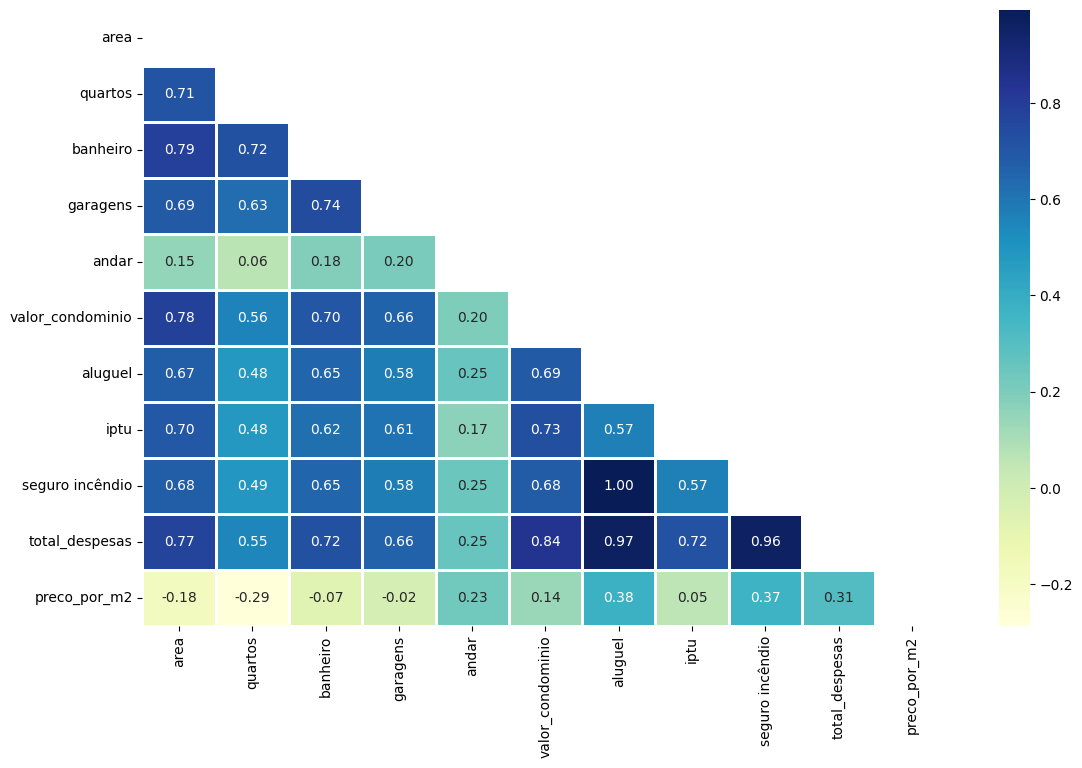

In [8]:
# Mapa de correlação
numeric_columns = df_translated.select_dtypes(include=[np.number]).columns
correlation_matrix = df_translated[numeric_columns].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
# Mapa de calor
plt.figure(figsize=(13, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', mask=mask, linewidths=2, cmap='YlGnBu')
plt.plot()

Text(0.5, 1.0, 'Cidades x Aluguel (R$)')

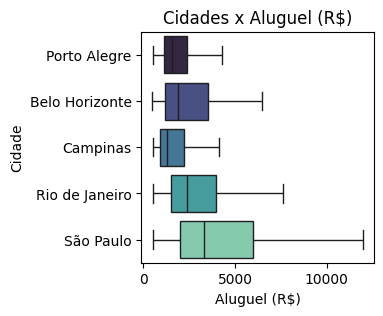

In [9]:
# Plotando um boxplot dos valores de aluguel x cidade do dataframe
plt.figure(figsize=(3, 3))
sns.boxplot(y=df_translated['cidade'], x=df_translated['aluguel'], showfliers=False, palette='mako', hue=df_translated['cidade'])
plt.ylabel('Cidade')
plt.xlabel('Aluguel (R$)')
plt.title('Cidades x Aluguel (R$)')

Estimando os coeficientes através do método dos mínimos quadrados:

\begin{cases}
    \hat{\beta}_1=\frac{\sum_{i=1}^n (x_i- \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2} = \frac{S{xy}}{S{xx}}\\
    \hat{\beta}_0= \bar{y}-\hat{\beta_1}\bar{x}
    \end{cases}

In [10]:
from IPython.display import Markdown

equation = r"$$RSE = \sqrt{\frac{1}{n-2}\sum_{i=1}^n (y_i-\hat{y}_i)^2}$$"
Markdown(equation)


$$RSE = \sqrt{\frac{1}{n-2}\sum_{i=1}^n (y_i-\hat{y}_i)^2}$$

In [11]:
from statistics import variance
import math

# Função para estimar os coeficientes da regressão linear (b0 e b1)
def estimate_coef(x, y):
    # Calcula o número de observações
    number = np.size(x)

    # Calcula as médias de x e y
    mx, my = np.mean(x), np.mean(y)

    # Calcula a soma dos produtos cruzados e a soma dos quadrados de x
    SSxy = np.sum(y * x) - number * my * mx
    SSxx = np.sum(x * x) - number * mx * mx

    # Calcula os coeficientes da regressão linear
    b1 = SSxy / SSxx
    b0 = my - b1 * mx

    return(b0, b1)

# Função para mostrar os dados e a linha de regressão
def plot_regression_line(x, y, b):
    plt.scatter(x, y, color='b', marker='o', s=50)

    # Calcula os valores preditos usando os coeficientes estimados
    y_pred = b[0] + b[1] * x

    # Linha de regressão
    plt.plot(x, y_pred, color='r')

    plt.xlabel(x.name, fontsize=15)
    plt.ylabel(y.name, fontsize=15)
    plt.show(True)

    plt.figure(figsize=(18, 6))
    
    sns.regplot(x=df_translated['seguro incêndio'], y=df_translated['aluguel'], line_kws={'color' : 'r'})
    plt.xticks(np.arange(df_translated['seguro incêndio'].min(), df_translated['seguro incêndio'].max(), step=20))
    
    plt.show()

Quantificando a acurácia do modelo, usando o erro padrão residual (residual standard error) e calculando o R2:

Como os erros da regressão não são conhecidos, o estimador
do desvio padrão da regressão (SER – Standard Error of Regression)
é calculado a partir dos resíduos da regressão por mínimos quadrados
ordinários.Destaca-se que a divisão por n-2 na equação se faz necessária
em função do fato de que dois parâmetros da regressão são estimados b0 e b1.

In [12]:
from IPython.display import Markdown

equation = r"$$R^2 = 1-\frac{\sum_{i=1}^n (y_i-\hat{y}_i)^2}{\sum_{i=1}^n(y_i-\bar{y})^2}, \quad 0\leq R^2\leq 1$$"
Markdown(equation)


$$R^2 = 1-\frac{\sum_{i=1}^n (y_i-\hat{y}_i)^2}{\sum_{i=1}^n(y_i-\bar{y})^2}, \quad 0\leq R^2\leq 1$$

In [13]:
def RSE_R2(x, y, b):
    number = len(y)
    RSE = 0
    c1 = 0
    c2 = 0
    ym = np.mean(y)
    
    for i in range(0, number):
        y_pred = b[0] + x[i] * b[1]
        # Informação para o cálculo de RSE
        RSE += (y[i] - y_pred) ** 2
        # Informação para o cálculo de R2
        c1 += (y[i] - y_pred) ** 2
        c2 += (y[i] - ym) ** 2

    RSE = math.sqrt(RSE / (number - 2))
    R2 = 1 - c1 / c2
    
    return RSE, R2

Estimativa dos coeficientes:
b0 = -29.743869786802406 
b1 = 77.776496308936
RSE:  303.41455273145993
R2:  0.9907471770194736


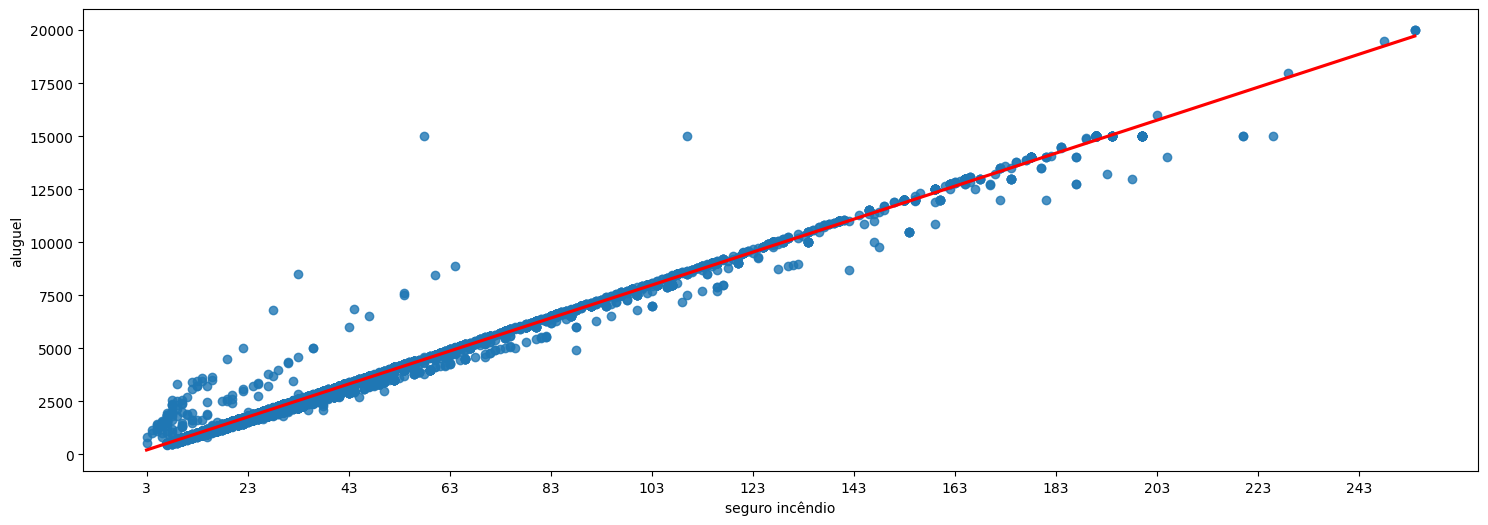

In [14]:
b_1 = estimate_coef(np.array(df_translated['seguro incêndio']), np.array(df_translated['aluguel']))
print(f'Estimativa dos coeficientes:\nb0 = {b_1[0]} \nb1 = {b_1[1]}')

# Mostrando RSE e R2 do gráfico de seguro de incêndio x aluguel
for index, i in enumerate(RSE_R2(df_translated['seguro incêndio'], df_translated['aluguel'], b_1)):
    if index == 0:
        print('RSE: ', i)
    if index == 1:
        print('R2: ', i)

#plot_regression_line(df_translated['seguro incêndio'], df_translated['aluguel'], b_1)

plt.figure(figsize=(18, 6))

sns.regplot(x=df_translated['seguro incêndio'], y=df_translated['aluguel'], line_kws={'color' : 'r'})
plt.xticks(np.arange(df_translated['seguro incêndio'].min(), df_translated['seguro incêndio'].max(), step=20))

plt.show()


O seguro de incêndio está positivamente relacionado com o preço de aluguel. A maioria dos valores está entre 3 e 200.

Estimativa dos coeficientes:
b0 = 86.53801686170345 
b1 = 0.687422000857568
RSE:  809.4299626171729
R2:  0.9341493611554481


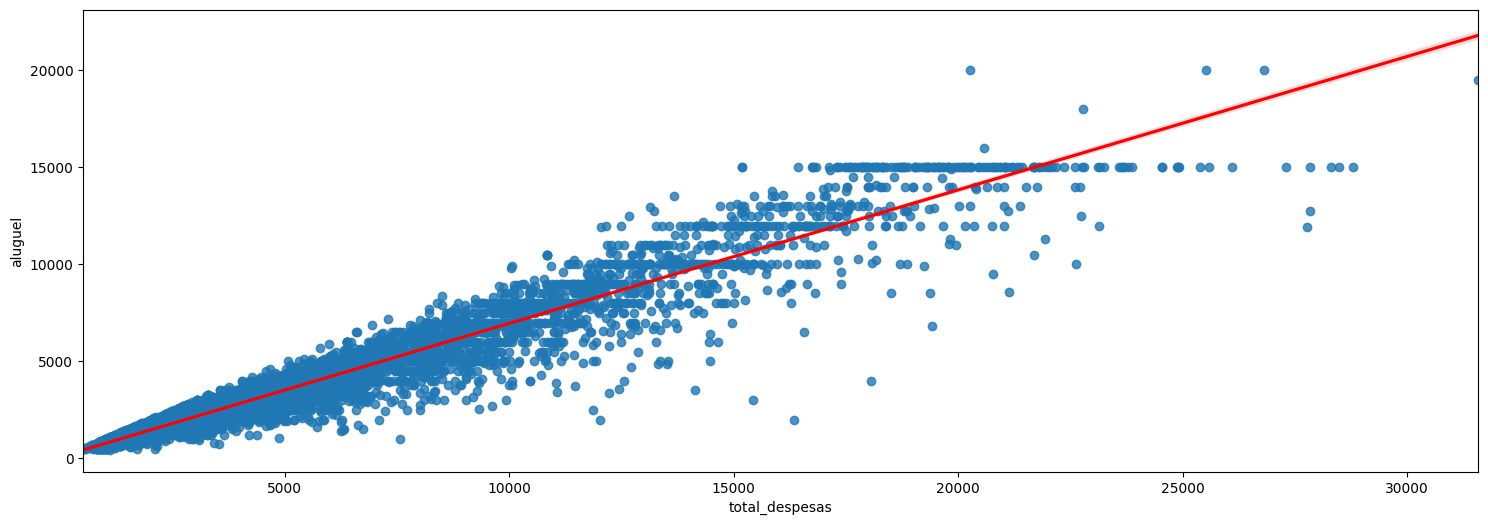

In [15]:
b_2 = estimate_coef(np.array(df_translated['total_despesas']), np.array(df_translated['aluguel']))
print(f'Estimativa dos coeficientes:\nb0 = {b_2[0]} \nb1 = {b_2[1]}')


# Mostrando RSE e R2 do gráfico de despesas totais x aluguel
for index, i in enumerate(RSE_R2(df_translated['total_despesas'], df_translated['aluguel'], b_2)):
    if index == 0:
        print('RSE: ', i)
    if index == 1:
        print('R2: ', i)

#plot_regression_line(df_translated['total_despesas'], df_translated['aluguel'], b_2)

plt.figure(figsize=(18, 6))

sns.regplot(x=df_translated['total_despesas'], y=df_translated['aluguel'], line_kws={'color' : 'r'})
plt.autoscale(enable=True, axis='x', tight=True)

plt.show()


Estimativa dos coeficientes:
b0 = 186.75651261315488 
b1 = 105.58222259484555
RSE:  1225.9284500998392
R2:  0.9235878849284411


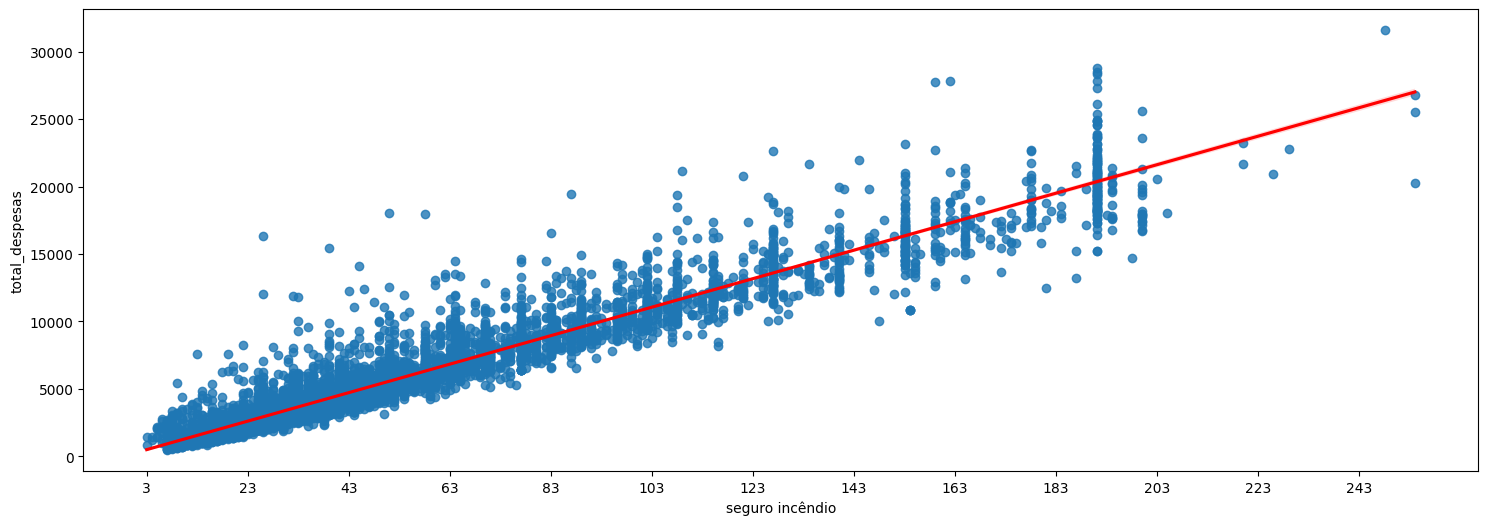

In [16]:
b_3 = estimate_coef(np.array(df_translated['seguro incêndio']), np.array(df_translated['total_despesas']))
print(f'Estimativa dos coeficientes:\nb0 = {b_3[0]} \nb1 = {b_3[1]}')

# Mostrando RSE e R2 do gráfico de seguro incêndio x despesas totais
for index, i in enumerate(RSE_R2(df_translated['seguro incêndio'], df_translated['total_despesas'], b_3)):
    if index == 0:
        print('RSE: ', i)
    if index == 1:
        print('R2: ', i)

#plot_regression_line(df_translated['seguro incêndio'], df_translated['total_despesas'], b_3)

plt.figure(figsize=(18, 6))

sns.regplot(x=df_translated['seguro incêndio'], y=df_translated['total_despesas'], line_kws={'color' : 'r'})
plt.xticks(np.arange(df_translated['seguro incêndio'].min(), df_translated['seguro incêndio'].max(), step=20))

plt.show()

O seguro de incêndio está positivamente relacionado com o valor total das despesas.

In [17]:
# Adiciona a função para plotar o gráfico de Resíduos x Fitted values
def plot_residuos_versus_ajustes(residuos, fitted_values):
    #quantis_teoricos = [range(0, len(residuos))]
    
    # Cria o gráfico de dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(fitted_values, residuos, edgecolors='k', facecolors='none')
    plt.title('Gráfico de Probabilidade Normal dos Resíduos')
    plt.xlabel('Fitted Values')
    plt.ylabel('Resíduos')

    # Adiciona grade
    plt.grid(True)

    # Exibe o gráfico
    plt.show()

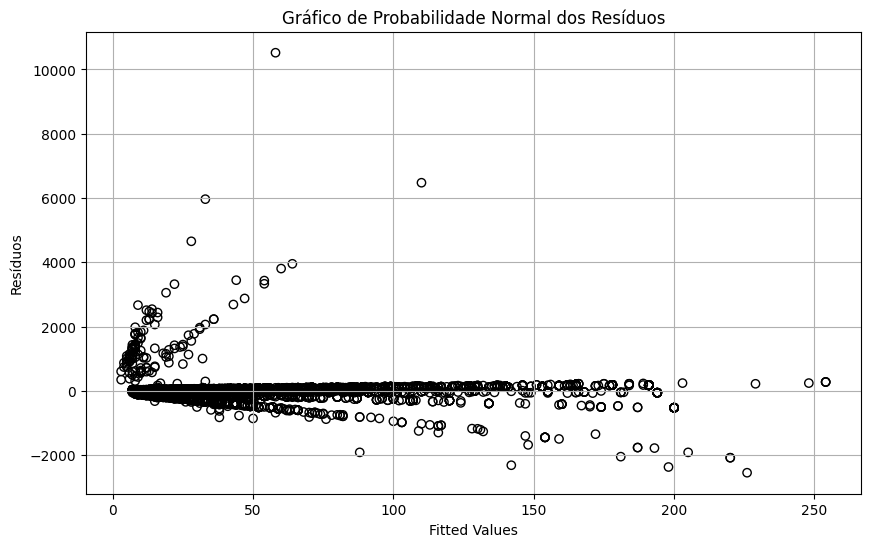

In [18]:
# Calcula os resíduos e os valores de ajuste
fitted_values = b_1[0] + b_1[1] * df_translated['seguro incêndio']
residuos = df_translated['aluguel'] - fitted_values

# Plota o gráfico de residuos x ajustes
plot_residuos_versus_ajustes(residuos, df_translated['seguro incêndio'])

In [19]:
from scipy import stats

# Adiciona a função para plotar o histograma dos resíduos padronizados
def plot_histograma_residuos_padronizados(residuos):
    # Calcula os resíduos padronizados
    residuos_padronizados = stats.zscore(residuos)

    # Cria o histograma normalizado
    plt.figure(figsize=(10, 6))
    sns.histplot(residuos_padronizados, kde=True, color='skyblue', bins=50, stat="density", edgecolor='black')

    # Adiciona a curva da distribuição normal padrão
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(residuos_padronizados), np.std(residuos_padronizados))
    plt.plot(x, p, 'k', linewidth=2)

    plt.title('Histograma Normalizado dos Resíduos Padronizados')
    plt.xlabel('Resíduos Padronizados')
    plt.ylabel('Densidade')
    plt.grid(True)

    # Exibe o gráfico
    plt.show()

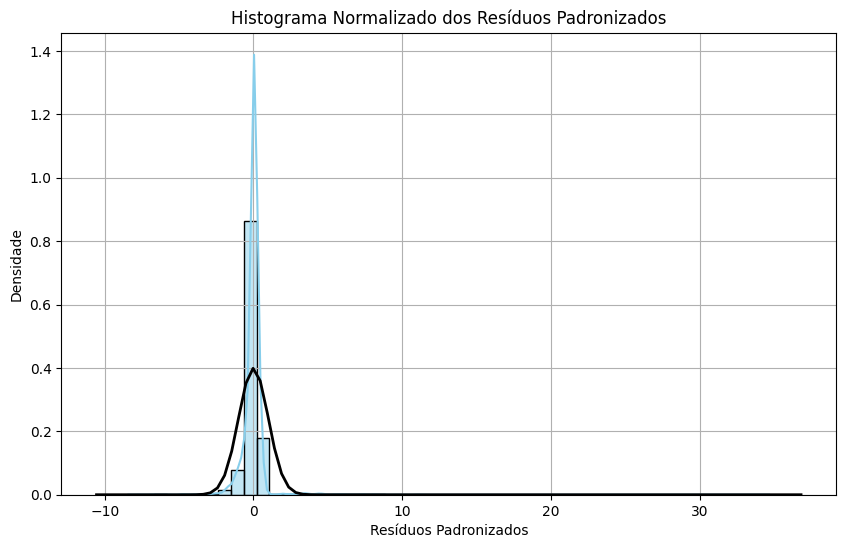

In [20]:
# Calcula os resíduos
residuos = df_translated['aluguel'] - (b_1[0] + b_1[1] * df_translated['seguro incêndio'])

# Plota o histograma dos resíduos padronizados
plot_histograma_residuos_padronizados(residuos)


In [25]:
filtro_rj = df_translated['cidade'] == 'Rio de Janeiro'
df_translated_rj = df_translated[filtro_rj]


[]

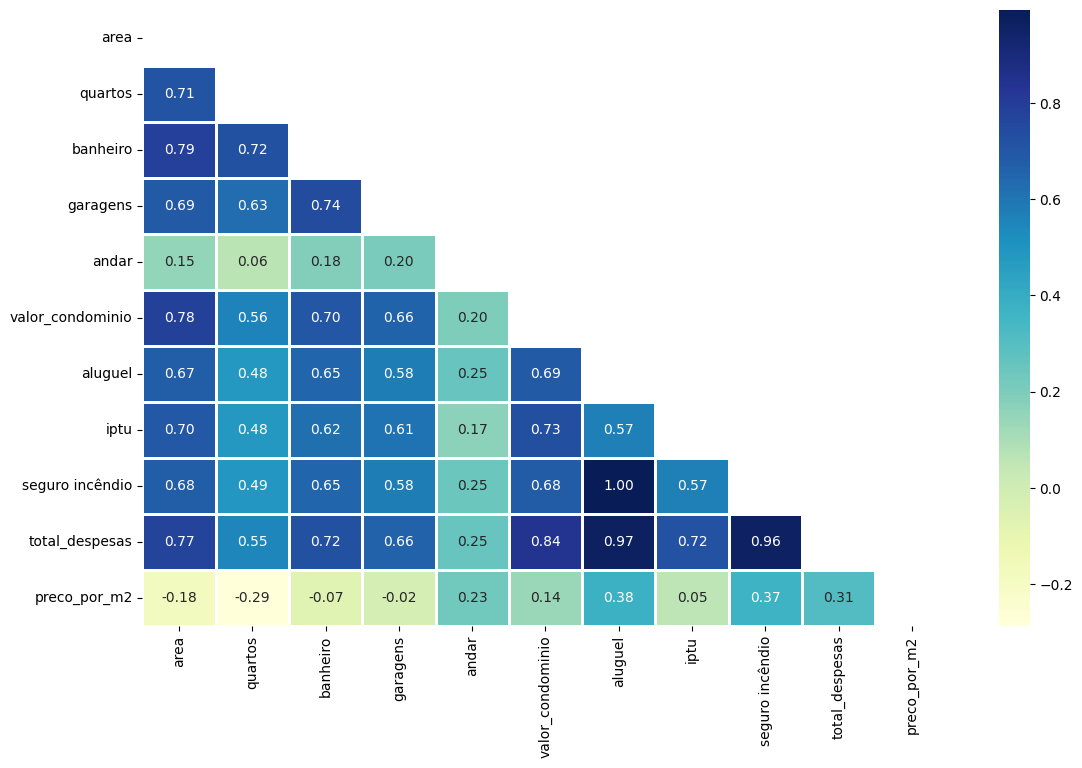

In [26]:
# Mapa de correlação
numeric_columns = df_translated_rj.select_dtypes(include=[np.number]).columns
correlation_matrix = df_translated_rj[numeric_columns].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
# Mapa de calor
plt.figure(figsize=(13, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', mask=mask, linewidths=2, cmap='YlGnBu')
plt.plot()

Estimativa dos coeficientes:
b0 = -29.743869786802406 
b1 = 77.776496308936
RSE:  303.41455273145993
R2:  0.9907471770194736


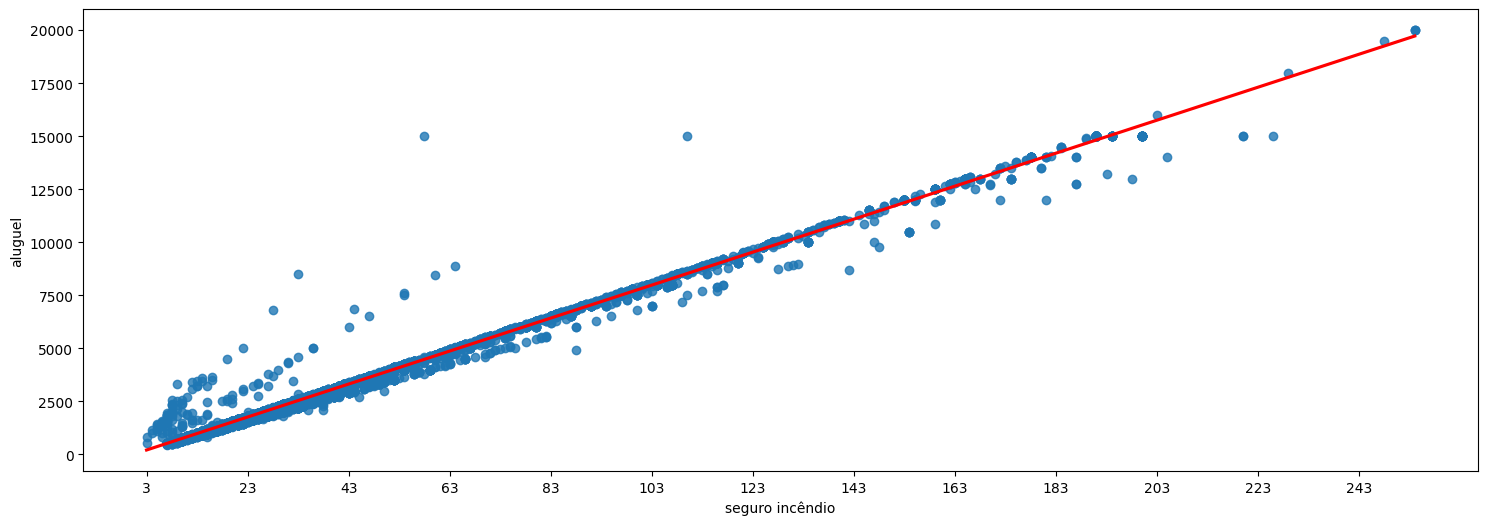

In [23]:


b_5 = estimate_coef(np.array(df_translated_rj['seguro incêndio']), np.array(df_translated_rj['aluguel']))
print(f'Estimativa dos coeficientes:\nb0 = {b_5[0]} \nb1 = {b_5[1]}')

# Mostrando RSE e R2 do gráfico de seguro de incêndio x aluguel
for index, i in enumerate(RSE_R2(df_translated_rj['seguro incêndio'], df_translated_rj['aluguel'], b_5)):
    if index == 0:
        print('RSE: ', i)
    if index == 1:
        print('R2: ', i)

#plot_regression_line(df_translated_rj['seguro incêndio'], df_translated_rj['aluguel'], b_1)

plt.figure(figsize=(18, 6))

sns.regplot(x=df_translated_rj['seguro incêndio'], y=df_translated_rj['aluguel'], line_kws={'color' : 'r'})
plt.xticks(np.arange(df_translated_rj['seguro incêndio'].min(), df_translated_rj['seguro incêndio'].max(), step=20))

plt.show()
